In [ ]:
import pandas as pd
import os
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

nlp = spacy.load("en_core_web_lg")

In [ ]:
cleaned_courses = pd.read_pickle('../data/cleaned_courses.pkl')

In [ ]:
##Keywords related with AI manually selected. This keywords are the result of:
# 1) individual and group brainstorm,
# 2) Wikipedia inputs on Artificial intelligence (https://en.wikipedia.org/wiki/Artificial_intelligence#History)
# 3) CoPilot inputs
AI_orig = [
        "Turing",
        "Turing machine",
        "Logic theorist",
        "Evolutionary computation",
        "Computational",
        "Computer vision",
        "Thinking Machines",
        "Symbolic reasoning",
        "Cellular Automata",
        "Cognitive revolution",
        "AI",
        "Artificial Intelligence",
        "Computational Intelligence",
        "Algorithm",
        "Machine Learning",
        "ML",
        "Supervised learning",
        "Unsupervised learning",
        "Semi-supervised learning",
        "Reinforcement learning",
        "Deep learning",
        "Neural networks",
        "Bayesian Networks",
        "Evolutionary Computation",
        "Natural language processing",
        "Data Science",
        "Computational Social Science",
        "Network Science",
        "Large Language Models",
    ]
AI = sorted(AI_orig)

In [ ]:
## Preprocessing functions to apply to catalogs' aggregated course descriptions
def remove_double_spaces(text):
    if not text:
        return ""
    return " ".join(text.split())


def remove_paragraphs_dash(text):
    return re.sub(r"-\n", "", text)


def remove_paragraphs(text):
    return re.sub("\n", " ", text)

In [ ]:
uvm = cleaned_courses[cleaned_courses['ipeds_id'] == '231174'].copy()
ucla = cleaned_courses[cleaned_courses['ipeds_id'] == '110662'].copy()
und = cleaned_courses[cleaned_courses['ipeds_id'] == '200280'].copy()

# concat dataframes
selected_universities = pd.concat([uvm, ucla, und], ignore_index=True)
selected_universities.info()

In [56]:
# get rows where start_yr >= 2000 for ucla
ucla_2000 = selected_universities[(selected_universities['ipeds_id'] == '110662') & (selected_universities['start_yr'] >= 2000)].copy()
ucla_2000.head()

ipeds_id cat_type  start_yr  end_yr  page_num  col_num     type  \
221825   110662       ug      2020    2021       504        0  courses   
221992   110662     both      2001    2003        82        0  courses   
222067   110662       ug      2019    2020       538        1  courses   
222068   110662       ug      2019    2020       538        1  courses   
222069   110662       ug      2019    2020       538        1  courses   

        annote_id                                         Department Number  \
221825     700020                                          Sociology   191D   
221992     778711  Introduction to American Indian Studies (Ameri...     10   
222067     773534                                             Korean   101A   
222068     773534                                             Korean   130B   
222069     773534                                             Korean   130A   

                                           Title Description Prerequisites  \
221825                            Sociology 191D                       nan   
221992   Introduction to American Indian Studies                       nan   
222067  Upper-division elective for Korean track                             
222068  Upper-division elective for Korean track                             
222069  Upper-division elective for Korean track                             

       Credits                                            Teacher  decade  \
221825     nan                                                nan    2020   
221992     nan                                                nan    2000   
222067       3  {'Honorific': '', 'Name': '', 'Degree': '', 'P...    2010   
222068       3  {'Honorific': '', 'Name': '', 'Degree': '', 'P...    2010   
222069       3  {'Honorific': '', 'Name': '', 'Degree': '', 'P...    2010   

        quinquennium                                  DepartmentCleaned  \
221825          2020                                          sociology   
221992          2000  introduction to american indian studies (ameri...   
222067          2015                                             korean   
222068          2015                                             korean   
222069          2015                                             korean   

                                    combined_text  
221825                            Sociology 191D   
221992   Introduction to American Indian Studies   
222067  Upper-division elective for Korean track   
222068  Upper-division elective for Korean track   
222069  Upper-division elective for Korean track

In [ ]:
# Combine Title and Description for each course
# Handle missing values by filling with empty strings
selected_universities['combined_text'] = (
    selected_universities['Title'].fillna('') + ' ' + 
    selected_universities['Description'].fillna('')
)

# Apply preprocessing
courses_content = (
    selected_universities['combined_text']
    .apply(remove_double_spaces)
    .apply(remove_paragraphs)
    .apply(remove_paragraphs_dash)
    .to_numpy()
)

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X = model.encode(courses_content)


In [22]:
selected_universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899681 entries, 0 to 899680
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ipeds_id           899681 non-null  object
 1   cat_type           899681 non-null  object
 2   start_yr           899681 non-null  int64 
 3   end_yr             899681 non-null  int64 
 4   page_num           899681 non-null  int64 
 5   col_num            899681 non-null  int64 
 6   type               899681 non-null  object
 7   annote_id          899681 non-null  int64 
 8   Department         899681 non-null  object
 9   Number             899681 non-null  object
 10  Title              899681 non-null  object
 11  Description        899681 non-null  object
 12  Prerequisites      899681 non-null  object
 13  Credits            899681 non-null  object
 14  Teacher            899681 non-null  object
 15  decade             899681 non-null  int64 
 16  quinquennium       8

In [ ]:
query_vec = model.encode(AI_orig)

# Calculate cosine similarity between AI keywords and courses
similarities = cosine_similarity(query_vec, X)

# Create dataframe with similarities
# Creates a dataframe from the similarity matrix. The .T transposes it so now:

# Rows = 899,681 courses (one per row)
# Columns = 29 AI keywords (one column per keyword)
# Each cell = how similar that course is to that keyword
# Shape: (899681, 29)

df_similarities = pd.DataFrame(
    data=similarities.T,  # Transpose so rows=courses, columns=AI keywords
    columns=AI_orig
)

# Add back the course metadata
df_results = pd.concat([
    selected_universities[['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                'Department', 'DepartmentCleaned', 'Number', 'Title', 
                'Description', 'decade', 'quinquennium']].reset_index(drop=True),
    df_similarities.reset_index(drop=True) 
], axis=1)

# Melt to long format
# Instead of having one column per AI keyword, we have one row per (course, AI keyword) pair
df_overall = df_results.melt(
    id_vars=['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
             'Department', 'DepartmentCleaned', 'Number', 'Title', 
             'Description', 'decade', 'quinquennium'],
    value_vars=AI_orig,
    var_name='AI_word',
    value_name='cos'
)

# Create start_end_year column for plotting
df_overall['start_end_year'] = df_overall['start_yr'].astype(str) + '_' + df_overall['end_yr'].astype(str)

In [58]:
def inspect_catalog(df, ipeds_id, start_year, end_year):
    """
    Inspect courses in a specific catalog.
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe to search (e.g., selected_universities)
    ipeds_id : str
        The IPEDS ID of the university (e.g., '110662' for UCLA)
    start_year : int
        The catalog start year
    end_year : int
        The catalog end year
    
    Returns:
    --------
    DataFrame of unique courses in that catalog
    """
    
    map_ipeds_name = {
        "110662": "University of California-Los Angeles",
        "200280": "University of North Dakota",
        "231174": "University of Vermont",
    }
    # Filter to the specific catalog
    catalog = df[
        (df['ipeds_id'] == ipeds_id) & 
        (df['start_yr'] == start_year) &
        (df['end_yr'] == end_year)
    ]
    # get start_yr and end_yr for ipeds_id
    # sort chronologically
    catalog_years = df[(df['ipeds_id'] == ipeds_id)][['start_yr', 'end_yr']].drop_duplicates().sort_values(['start_yr', 'end_yr'])
    # currently it truncates the printout and we need to see all rows
    # pd.set_option('display.max_rows', None)
    # print(f"Available catalog years for {map_ipeds_name.get(ipeds_id, ipeds_id)}:")
    # print(catalog_years)
    # Print summary statistics
    print(f"=== Catalog: {map_ipeds_name.get(ipeds_id, ipeds_id)} ({start_year}-{end_year}) ===")
    print(f"Total rows in that catalog: {len(catalog)}")
    print(f"Unique courses (by Title): {catalog['Title'].nunique()}")
    print(f"Unique courses (by Number): {catalog['Number'].nunique()}")
    print(f"Unique courses (by Dept+Number): {catalog.groupby(['Department', 'Number']).ngroups}")
    
    # Get unique courses
    unique_courses = catalog[['Department', 'Number', 'Title']].drop_duplicates()
    
    print(f"\nActual course titles:")
    print(unique_courses)
    
    return unique_courses

# Example usage:
inspect_catalog(selected_universities, '110662', 2001, 2003)

=== Catalog: University of California-Los Angeles (2001-2003) ===
Total rows in that catalog: 11175
Unique courses (by Title): 7664
Unique courses (by Number): 3236
Unique courses (by Dept+Number): 10736

Actual course titles:
                                               Department  \
221992  Introduction to American Indian Studies (Ameri...   
222286                                            History   
222287                                            History   
222288                                            History   
222289                                            History   
222290                                            History   
222291                                            History   
222292                                            History   
222293                                            History   
222294                                            History   
222295                        Chicana and Chicano Studies   
222296                        Chicana and

Department  \
221992  Introduction to American Indian Studies (Ameri...   
222286                                            History   
222287                                            History   
222288                                            History   
222289                                            History   
222290                                            History   
222291                                            History   
222292                                            History   
222293                                            History   
222294                                            History   
222295                        Chicana and Chicano Studies   
222296                        Chicana and Chicano Studies   
222297                                            History   
222298                                            History   
223028                                              Music   
223029                                              Music   
223030                                              Music   
223031                                              Music   
223032    Lesbian, Gay, Bisexual, and Transgender Studies   
223183                                  Political Science   
223184                            Political Science Field   
223736                                            History   
223737                                            History   
223738                                            History   
223739                                            History   
223740                                            History   
223741                                            History   
223742                                            History   
223743                                            History   
223744                                            History   
223745                                            History   
223746                                            History   
223747                                            History   
223748                                            History   
223749                                            History   
223750                                            History   
223777                                          Sociology   
223778                                          Sociology   
223779                                          Sociology   
223780                                            History   
223781                                            History   
223782                                            History   
223783                                            History   
223784                                            History   
223785                                            History   
223786                                            History   
223787                                            History   
223788                                          Geography   
223789                                            History   
223790                                            History   
223791                                            History   
223792                                            History   
223793                                            History   
223794                                          Geography   
223795                                          Economics   
223796                                            History   
223797                              Communication Studies   
223798                                            History   
223799                                            History   
223800                                            History   
223801                                            History   
223802                                            History   
223803                                            History   
223804                                            History   
223805                                            History   
223806               

In [27]:
# convert similarites to a dataframe
# df_similarities = pd.DataFrame(similarities.T, columns=AI_orig)
# df_similarities.head()
df_overall.head()

ipeds_id cat_type  start_yr  end_yr Department DepartmentCleaned Number  \
0   231174       ug      2000    2001        NFS               nfs     43   
1   231174       ug      2000    2001        NFS               nfs    250   
2   231174       ug      2000    2001        NFS               nfs    150   
3   231174       ug      2000    2001        NFS               nfs    242   
4   231174       ug      2000    2001        NFS               nfs    241   

                                               Title  \
0                          Fundamentals of Nutrition   
1                    Clients and Populations at Risk   
2  Health Assessment and Promotion of Individuals...   
3         Caring for Clients and Populations at Risk   
4         Health Care Issues for Populations at Risk   

                                         Description  decade  quinquennium  \
0  Comprehensive study of specific nutrients in t...    2000          2000   
1  The role of the nurse within a multidisciplina...    2000          2000   
2  Assessment of health, prevention of illness wi...    2000          2000   
3  Through seminar and practicum the student will...    2000          2000   
4  Focus on populations at risk and pertinent hea...    2000          2000   

  AI_word       cos start_end_year  
0  Turing -0.087509      2000_2001  
1  Turing  0.086784      2000_2001  
2  Turing  0.007315      2000_2001  
3  Turing  0.089393      2000_2001  
4  Turing -0.052755      2000_2001

In [36]:
# Aggregate to catalog level
# (26090749, 14) -> (11194, 10)
# I believe this dilutes thes signal as we are averaging over many courses
# so if one out of 28 courses is strong it is pulled down by the rest
df_catalog_agg = df_overall.groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year', 'AI_word']
).agg({
    'cos': ['mean', 'max', 'count']
}).reset_index()

df_catalog_agg.columns = ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                          'start_end_year', 'AI_word', 'cos_mean', 'cos_max', 'num_courses']

# Choose which metric to use (mean or max)
df_catalog_agg['cos'] = df_catalog_agg['cos_mean']  # or use cos_max
use_threshold = True  # toggle this
threshold = 0.6
if use_threshold:
    df_90pp_final = df_catalog_agg[df_catalog_agg['cos'] >= threshold].copy()
else:
    df_90pp_final = df_catalog_agg.copy()

cos_values = df_90pp_final['cos'].dropna()
if cos_values.empty:
    vmin, vmax = 0.0, 1.0
else:
    vmin, vmax = cos_values.min(), cos_values.max()
# Check what you have
print(f"Catalog aggregations: {len(df_catalog_agg)}")
print(f"Unique catalogs: {df_catalog_agg.groupby(['ipeds_id', 'cat_type', 'start_yr', 'end_yr']).ngroups}")


# NEW COURSE LEVEL APPROACH
# For each course, find its maximum similarity across all AI keywords
# this will be best for timeseries plotting later
df_course_level = df_overall.groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year',
     'Department', 'DepartmentCleaned', 'Number', 'Title', 'Description']
).apply(lambda x: pd.Series({
    'max_cos_similarity': x['cos'].max(),
    'best_matching_keyword': x.loc[x['cos'].idxmax(), 'AI_word']
})).reset_index()

print(f"Course-level data shape: {df_course_level.shape}")
print(df_course_level.head(10))


Catalog aggregations: 11194
Unique catalogs: 386


/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_55291/1341700556.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: pd.Series({


Course-level data shape: (896770, 12)
  ipeds_id cat_type  start_yr  end_yr start_end_year Department  \
0   110662     both      1883    1884      1883_1884   Language   
1   110662     both      1883    1884      1883_1884   Language   
2   110662     both      1883    1884      1883_1884   Language   
3   110662     both      1883    1884      1883_1884   Language   
4   110662     both      1883    1884      1883_1884   Language   
5   110662     both      1883    1884      1883_1884   Language   
6   110662     both      1883    1884      1883_1884   Language   
7   110662     both      1883    1884      1883_1884   Language   
8   110662     both      1883    1884      1883_1884   Language   
9   110662     both      1883    1884      1883_1884   Language   

  DepartmentCleaned Number                                             Title  \
0          language     27                 Analysis of Course of Instruction   
1          language     27              Development of power to 

In [37]:
df_course_level.to_pickle('../data/selected_universities_course_level_embeddings.pkl')

In [ ]:
# Create keyword-level counts per catalog
# For each catalog and keyword, count courses above threshold
# Restore robust map_ipeds_name dictionary
map_ipeds_name = {
    "110662": "University of California-Los Angeles",
    "200280": "University of North Dakota",
    "231174": "University of Vermont",
    # Add more ipeds_id:name pairs here as needed
}
df_keyword_counts = df_overall[df_overall['cos'] >= threshold].groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year', 'AI_word']
).agg({
    'cos': 'count'  # Count courses above threshold for each keyword
}).reset_index()

df_keyword_counts.columns = ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 
                              'start_end_year', 'AI_word', 'num_courses']

# Set consistent color scale limits
vmin = 0
vmax = df_keyword_counts['num_courses'].max()

print(f"Color scale: {vmin} to {vmax} courses per keyword")

# Create subplots
unique_ipeds = df_keyword_counts["ipeds_id"].unique()
unique_cat_types = df_keyword_counts["cat_type"].unique()

fig, axes = plt.subplots(
    nrows=len(unique_cat_types),
    ncols=len(unique_ipeds),
    figsize=(10 * len(unique_ipeds), 10 * len(unique_cat_types)),
)

# Make sure axes is 2D
if len(unique_cat_types) == 1:
    axes = axes.reshape(1, -1)
if len(unique_ipeds) == 1:
    axes = axes.reshape(-1, 1)

# Loop through each combination
for i, cat_type in enumerate(unique_cat_types):
    for j, ipeds in enumerate(unique_ipeds):
        ax = axes[i][j]
        data = df_keyword_counts[
            (df_keyword_counts["ipeds_id"] == ipeds)
            & (df_keyword_counts["cat_type"] == cat_type)
        ]
        
        if not data.empty:
            # Pivot with keywords as columns, time as rows
            pivot_table = data.pivot(
                index="start_end_year", 
                columns="AI_word", 
                values="num_courses"
            )
            
            # Fill NaN with 0 (no courses for that keyword in that catalog)
            pivot_table = pivot_table.fillna(0)
            
            # Reorder columns to match AI_orig order
            pivot_table = pivot_table[[col for col in AI_orig if col in pivot_table.columns]]
            
            sns.heatmap(
                pivot_table,
                ax=ax,
                cmap=sns.color_palette("mako_r", as_cmap=True),
                vmin=vmin,
                vmax=vmax,
                cbar_kws={'label': 'Number of AI courses'}
            )
            ax.set_title(
                f"{map_ipeds_name[ipeds]}\nCatalog Type: {cat_type}\n"
                f"Total AI courses: {data['num_courses'].sum()}"
            )
            ax.set_ylabel("Catalog Year")
            ax.set_xlabel("AI Keyword")
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        else:
            ax.axis("off")
            ax.set_title(
                f"No AI courses for\n{map_ipeds_name[ipeds]}\nCatalog Type: {cat_type}"
            )

plt.tight_layout()
plt.savefig('../figures/heatmaps_ai_courses_by_keyword.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Filter to AI courses above threshold
ai_courses = df_course_level[df_course_level['max_cos_similarity'] >= threshold]

# Count courses per university per catalog year
df_timeseries = ai_courses.groupby(
    ['ipeds_id', 'cat_type', 'start_yr', 'end_yr', 'start_end_year']
).size().reset_index(name='num_ai_courses')

# Sort by start_yr for proper time series plotting
df_timeseries = df_timeseries.sort_values('start_yr')

print(f"Time series data shape: {df_timeseries.shape}")
print(df_timeseries.head(10))

Time series data shape: (259, 6)
   ipeds_id cat_type  start_yr  end_yr start_end_year  num_ai_courses
0    110662     both      1883    1884      1883_1884               1
79   200280     both      1912    1913      1912_1913               2
80   200280     both      1926    1927      1926_1927               1
81   200280     both      1929    1930      1929_1930               1
1    110662     both      1929    1930      1929_1930               1
82   200280     both      1931    1932      1931_1932               1
83   200280     both      1932    1933      1932_1933               1
2    110662     both      1932    1933      1932_1933               2
3    110662     both      1934    1935      1934_1935               1
4    110662     both      1936    1937      1936_1937               1


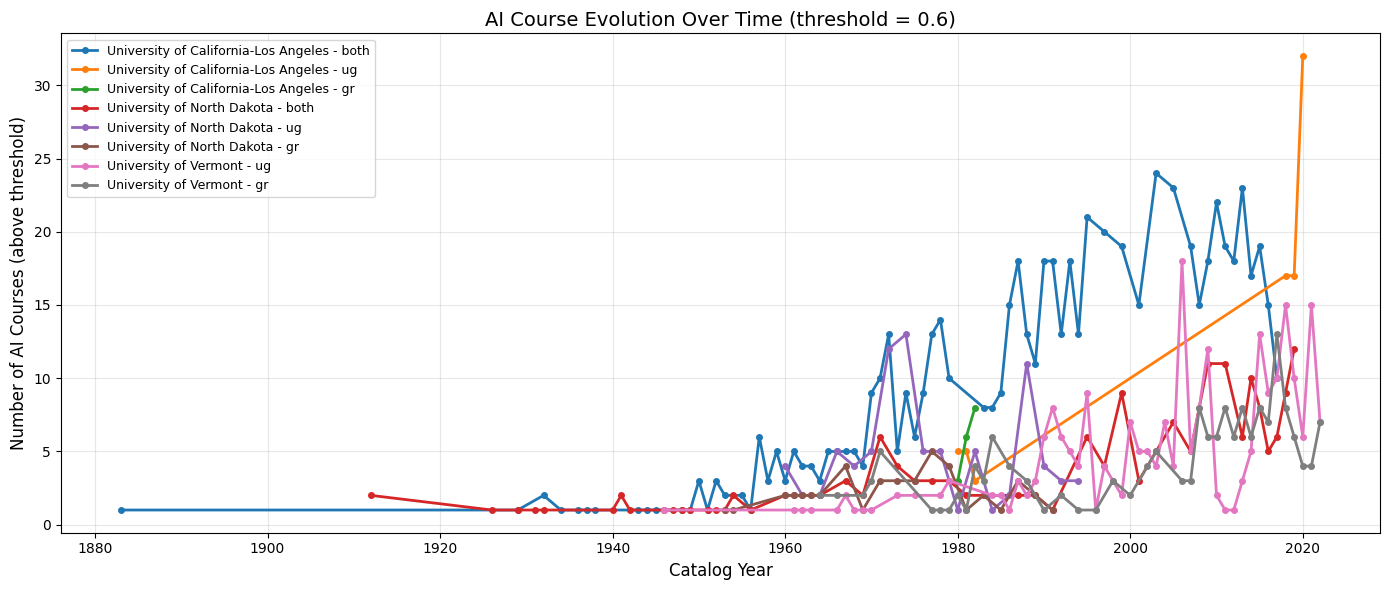

In [45]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Define line styles for different catalog types
cat_type_styles = {
    'undergraduate': '--',
    'graduate': ':',
    'both': '-'
}

# Plot each university and catalog type combination
for ipeds in df_timeseries['ipeds_id'].unique():
    for cat_type in df_timeseries['cat_type'].unique():
        data = df_timeseries[
            (df_timeseries['ipeds_id'] == ipeds) & 
            (df_timeseries['cat_type'] == cat_type)
        ]
        
        if not data.empty:
            linestyle = cat_type_styles.get(cat_type, '-')
            label = f"{map_ipeds_name[ipeds]} - {cat_type}"
            
            ax.plot(data['start_yr'], data['num_ai_courses'], 
                    marker='o', linewidth=2, markersize=4,
                    linestyle=linestyle,
                    label=label)

ax.set_xlabel('Catalog Year', fontsize=12)
ax.set_ylabel('Number of AI Courses (above threshold)', fontsize=12)
ax.set_title(f'AI Course Evolution Over Time (threshold = {threshold})', fontsize=14)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/timeseries_ai_courses.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# THIS EXPLAINS THE LARGE GAP IN DATA FOR UCLA
# Check for overlapping catalog years
ucla_ug = selected_universities[
    (selected_universities['ipeds_id'] == '110662') & 
    (selected_universities['cat_type'] == 'ug')
][['start_yr', 'end_yr']].drop_duplicates().sort_values('start_yr')

print("UCLA Undergraduate catalog years:")
print(ucla_ug)


UCLA Undergraduate catalog years:
        start_yr  end_yr
225559      1980    1981
377075      1981    1982
583908      1982    1983
222864      2018    2019
222067      2019    2020
221825      2020    2021


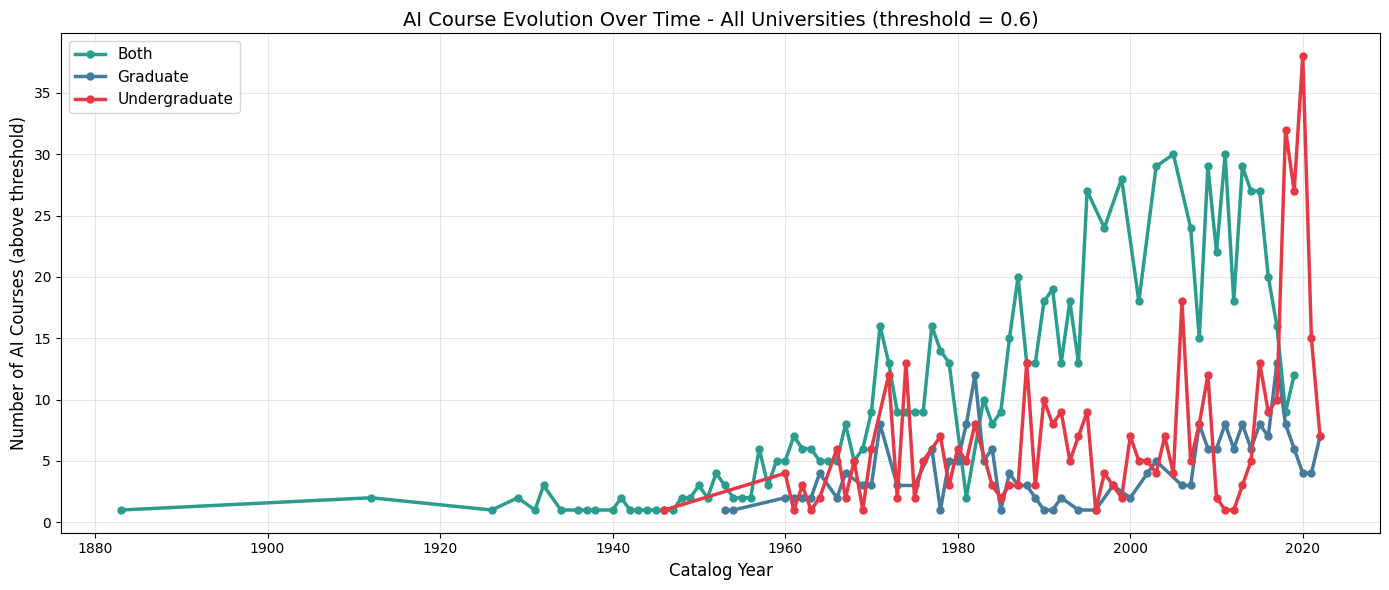

In [46]:
# Aggregate across all universities, grouping only by catalog type and year
df_plot = df_timeseries.groupby(['cat_type', 'start_yr']).agg({
    'num_ai_courses': 'sum'
}).reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Define better colors and styles for different catalog types - FIXED keys
cat_type_styles = {
    'ug': {'linestyle': '-', 'color': '#E63946', 'label': 'Undergraduate'},  # Red
    'gr': {'linestyle': '-', 'color': '#457B9D', 'label': 'Graduate'},  # Blue
    'both': {'linestyle': '-', 'color': '#2A9D8F', 'label': 'Both'}  # Teal/Green
}

# Plot each catalog type
for cat_type in df_plot['cat_type'].unique():
    data = df_plot[df_plot['cat_type'] == cat_type]
    
    style = cat_type_styles.get(cat_type, {'linestyle': '-', 'color': 'gray', 'label': cat_type})
    
    ax.plot(data['start_yr'], data['num_ai_courses'], 
            marker='o', linewidth=2.5, markersize=5,
            linestyle=style['linestyle'],
            color=style['color'],
            label=style['label'])

ax.set_xlabel('Catalog Year', fontsize=12)
ax.set_ylabel('Number of AI Courses (above threshold)', fontsize=12)
ax.set_title(f'AI Course Evolution Over Time - All Universities (threshold = {threshold})', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/timeseries_ai_courses_combined.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print("Unique catalog types:")
print(df_timeseries['cat_type'].unique())
print("\nValue counts:")
print(df_timeseries['cat_type'].value_counts())

Unique catalog types:
['both' 'ug' 'gr']

Value counts:
cat_type
both    120
ug       76
gr       63
Name: count, dtype: int64
